In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from Bio import PDB
from sklearn.metrics import roc_curve, auc
import pandas as pd
import json
import os
import gc
from Bio.SeqUtils import seq1
from Bio.PDB import PDBList, PDBParser
from Bio import SeqIO
import requests
from io import StringIO
import time
from tqdm import tqdm
import concurrent.futures
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [3]:
amino_acids = 'ACDEFGHIKLMNPQRSTVWYX'
NUM_AA = len(amino_acids)
aa_to_int = {aa: idx for idx, aa in enumerate(amino_acids)}
def encode_sequence(seq, max_length):
    seq = seq.upper()
    int_seq = [aa_to_int.get(aa, NUM_AA-1) for aa in seq]  # Use 'X' index for unknowns
    if len(int_seq) < max_length:
        int_seq += [NUM_AA-1] * (max_length - len(int_seq))
    else:
        int_seq = int_seq[:max_length]
    one_hot = np.zeros((max_length, NUM_AA), dtype=np.float32)
    one_hot[np.arange(max_length), int_seq] = 1.0
    return one_hot

In [58]:
class ModifiedResNet18(nn.Module):
    def __init__(self, input_channels=1, pretrained=False):
        super(ModifiedResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=pretrained)
        self.resnet.conv1 = nn.Conv2d(
            input_channels,
            64,
            kernel_size=7,
            stride=1,
            padding=3,
            bias=False
        )
        self.resnet.maxpool = nn.Identity()
        self._modify_resnet_layers()
    def _modify_resnet_layers(self):
        for layer in [self.resnet.layer3, self.resnet.layer4]:
            for block in layer:
                block.conv1.stride = (1, 1)
                if block.downsample:
                    block.downsample[0].stride = (1, 1)
    def forward(self, x):
        # Collect intermediate features before residual connections
        features = {}
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        # Layer1
        before_layer1 = x.clone()
        x = self.resnet.layer1(x)
        features['layer1'] = before_layer1  # Features before skip connections in layer1
        # Layer2
        before_layer2 = x.clone()
        x = self.resnet.layer2(x)
        features['layer2'] = before_layer2  # Features before skip connections in layer2
        # Layer3
        before_layer3 = x.clone()
        x = self.resnet.layer3(x)
        features['layer3'] = before_layer3  # Features before skip connections in layer3
        # Layer4 (Final Output)
        x = self.resnet.layer4(x)
        features['layer4'] = x  
        return x, features  # Return final output and intermediate features

class ResNetAttentionModel(nn.Module):
    def __init__(self, num_classes=1, input_channels=1, seq_length=300):
        super(ResNetAttentionModel, self).__init__()
        self.seq_length = seq_length
        self.resnet = ModifiedResNet18(input_channels=input_channels, pretrained=False).to(device)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Pool to (batch_size, 512, 1, 1)
            nn.Flatten(),                  # Flatten to (batch_size, 512)
            nn.Linear(512, num_classes)    # Final classification layer
        )
    def forward(self, x):
        # Passes input through the modified ResNet18 to get features
        features, intermediate_features = self.resnet(x)  
        logits = self.classifier(features).squeeze(1) 
        # Extract intermediate features before residual connections
        feat_low = intermediate_features['layer1']   
        feat_mid = intermediate_features['layer2']   
        feat_high = intermediate_features['layer3']  
        feat_vhigh = intermediate_features['layer4']
        attention_low = self.generate_attention(feat_low, target_height=self.seq_length)
        attention_mid = self.generate_attention(feat_mid, target_height=self.seq_length)
        attention_high = self.generate_attention(feat_high, target_height=self.seq_length)
        attention_vhigh = self.generate_attention(feat_vhigh, target_height=self.seq_length)
        attention_combined = (attention_low + attention_mid + attention_high) / 3  # Simple average
        return logits, attention_combined, attention_low, attention_mid, attention_high, attention_vhigh
    def generate_attention(self, feature_map, target_height):
        """
        Generates attention maps from feature maps using non-trainable operations.
        Returns attention map of shape (batch_size, target_height)
        """
        attention = torch.mean(feature_map, dim=1, keepdim=True)
        attention = F.adaptive_avg_pool2d(attention, (self.seq_length, 1))  
        attention = attention.squeeze(3).squeeze(1) 
        return attention

SEQ_LENGTH = 300
model_check = ResNetAttentionModel(num_classes=1, input_channels=1, seq_length=SEQ_LENGTH)
saved_dict = torch.load('datasets/high_attention_NONNUM_60_ALPHA_3_EPOCH_32.pth', map_location=device)
model_check.load_state_dict(saved_dict)
model_check.to(device)
model_check.eval()

/opt/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/_1/y199p3xd06q8rxpp5cgxqq5m0000gq/T/ipykernel_5770/647206337.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_onl

ResNetAttentionModel(
  (resnet): ModifiedResNet18(
    (resnet): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): Identity()
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [50]:
def extract_attention(model, sequence, aa_to_int, max_length=300):
    model.eval()
    # Encode the sequence
    encoded_seq = encode_sequence(sequence, max_length)
    X = torch.tensor(encoded_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    X = X.to(device)
    with torch.no_grad():
        outputs, student_att, attention_low, attention_mid, attention_high, attention_vhigh= model(X)
        print(torch.sigmoid(outputs) > 0.5)
    att = attention_high
    att = att.cpu().numpy()
    return att

def map_attention_to_sequence(aggregated_attention, sequence):
    seq_length = len(sequence)
    attention_scores = aggregated_attention[:seq_length]
    return attention_scores

def plot_attention(sequence, attention_scores, functional_positions=None, save_path=None):
    plt.figure(figsize=(20, 5))
    plt.bar(range(len(sequence)), attention_scores, color='skyblue')
    plt.xlabel('Residue Position')
    plt.ylabel('Attention Score')
    plt.title('Attention Scores per Residue')
    if functional_positions:
        for pos in functional_positions:
            plt.axvline(x=pos-1, color='red', linestyle='--', alpha=0.5)
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches = 'tight')
        print(f"Bar plot saved as {save_path}")
    plt.show()
def plot_attention_heatmap(attention_scores, sequence, functional_positions=None, save_path = None):
    plt.figure(figsize=(20, 2))
    sns.heatmap([attention_scores], cmap='viridis', cbar=True)
    plt.xlabel('Residue Position')
    plt.yticks([])
    plt.title('Attention Heatmap')
    if functional_positions:
        for pos in functional_positions:
            plt.axvline(x=pos, color='red', linestyle='--', alpha=0.5)
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches = 'tight')
        print(f"Heatmap saved as {save_path}")
    plt.show()

def visualize_sequence_attention(model, sequence, functional_positions=None, max_length=300, top_n=30):
    # Truncate the sequence to max_length
    truncated_sequence = sequence[:max_length]
    truncated_functional_positions = [pos for pos in functional_positions if pos <= max_length] if functional_positions else []
    # Extract attention maps
    att = extract_attention(model, truncated_sequence, aa_to_int, max_length)
    # Aggregate attention (since only one attention map)
    aggregated_attention = att.squeeze() 
    attention_scores = aggregated_attention[:len(truncated_sequence)]
    if not isinstance(attention_scores, np.ndarray):
        attention_scores = attention_scores.numpy()
    top_n = min(top_n, len(attention_scores))  
    top_10_indices = np.argsort(attention_scores)[-top_n:][::-1]  # Descending order
    top_10_scores = attention_scores[top_10_indices]
    # Print top n attention positions and their scores
    print(f"Top {top_n} attention positions and scores:")
    for rank, (idx, score) in enumerate(zip(top_10_indices, top_10_scores), start=1):
        print(f"{rank}. Position: {idx + 1} (Residue: {truncated_sequence[idx]}), Score: {score:.4f}")
    #bar_plot_path = "attention_bar_plot.pdf"
    #heatmap_path = "attention_heatmap.pdf"
    # Plot using bar plot
    plot_attention(truncated_sequence, attention_scores, truncated_functional_positions, save_path=bar_plot_path)
    plot_attention_heatmap(attention_scores, truncated_sequence, truncated_functional_positions, save_path=heatmap_path)

In [44]:
def generate_roc_curve(model, sequence, pdb_file, functional_positions, threshold_distance=3.0, max_length=300, save_path = None):
    """
    Generates and plots the ROC curve based on attention scores and proximity to functional positions.
    """
    attention = extract_attention(model, sequence, aa_to_int, max_length=max_length)  
    attention_scores = attention.squeeze()[:max_length]  
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_file)
    model_pdb = next(structure.get_models())
    chain_pdb = next(model_pdb.get_chains())
    pdb_residues = list(chain_pdb.get_residues())
    # Ensures that sequence and PDB residues align
    if len(sequence) > len(pdb_residues):
        print("Warning: Sequence length is longer than number of residues in PDB. Truncating sequence.")
    elif len(sequence) < len(pdb_residues):
        print("Warning: Sequence length is shorter than number of residues in PDB. Truncating PDB residues.")
    # Truncate to the shorter length
    min_length = min(len(sequence), len(pdb_residues), max_length)
    sequence = sequence[:min_length]
    pdb_residues = pdb_residues[:min_length]
    attention_scores = attention_scores[:min_length]
    # Get the coordinates of functional positions
    functional_residues = []
    for pos in functional_positions:
        if pos < 1 or pos > len(pdb_residues):
            print(f"Functional position {pos} is out of range. Skipping.")
            continue
        residue = pdb_residues[pos - 1]  # Zero-based indexing
        # Use CA atom, if not present, use the first available atom
        if 'CA' in residue:
            ca = residue['CA'].get_vector()
        else:
            atoms = list(residue.get_atoms())
            if len(atoms) == 0:
                continue
            ca = atoms[0].get_vector()
        functional_residues.append(ca)
    # If within threshold_distance to any functional residue, else 0
    labels = []
    for idx, residue in enumerate(pdb_residues):
        if 'CA' in residue:
            ca = residue['CA'].get_vector()
        else:
            labels.append(0)
            continue
        # Calculate distance to all functional residues
        distances = [ca - functional_ca for functional_ca in functional_residues]
        distances = [d.norm() for d in distances]
        min_distance = min(distances) if distances else float('inf')
        label = 1 if min_distance <= threshold_distance else 0
        labels.append(label)
    attention_scores = np.array(attention_scores)
    labels = np.array(labels)
    # Compute ROC Curve
    fpr, tpr, thresholds = roc_curve(labels, attention_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Curve saved as {save_path}")
    plt.show()

tensor([True])
Top 30 attention positions and scores:
1. Position: 199 (Residue: D), Score: 0.7474
2. Position: 200 (Residue: S), Score: 0.7474
3. Position: 198 (Residue: G), Score: 0.7038
4. Position: 197 (Residue: Q), Score: 0.7038
5. Position: 63 (Residue: A), Score: 0.4603
6. Position: 64 (Residue: A), Score: 0.4603
7. Position: 202 (Residue: G), Score: 0.2019
8. Position: 201 (Residue: G), Score: 0.2019
9. Position: 65 (Residue: Y), Score: 0.1834
10. Position: 66 (Residue: K), Score: 0.1834
11. Position: 45 (Residue: Y), Score: 0.1825
12. Position: 46 (Residue: H), Score: 0.1825
13. Position: 55 (Residue: E), Score: 0.1495
14. Position: 56 (Residue: Q), Score: 0.1495
15. Position: 42 (Residue: N), Score: 0.1032
16. Position: 41 (Residue: L), Score: 0.1032
17. Position: 220 (Residue: C), Score: 0.0789
18. Position: 219 (Residue: G), Score: 0.0789
19. Position: 122 (Residue: R), Score: 0.0771
20. Position: 121 (Residue: S), Score: 0.0771
21. Position: 32 (Residue: E), Score: 0.0652


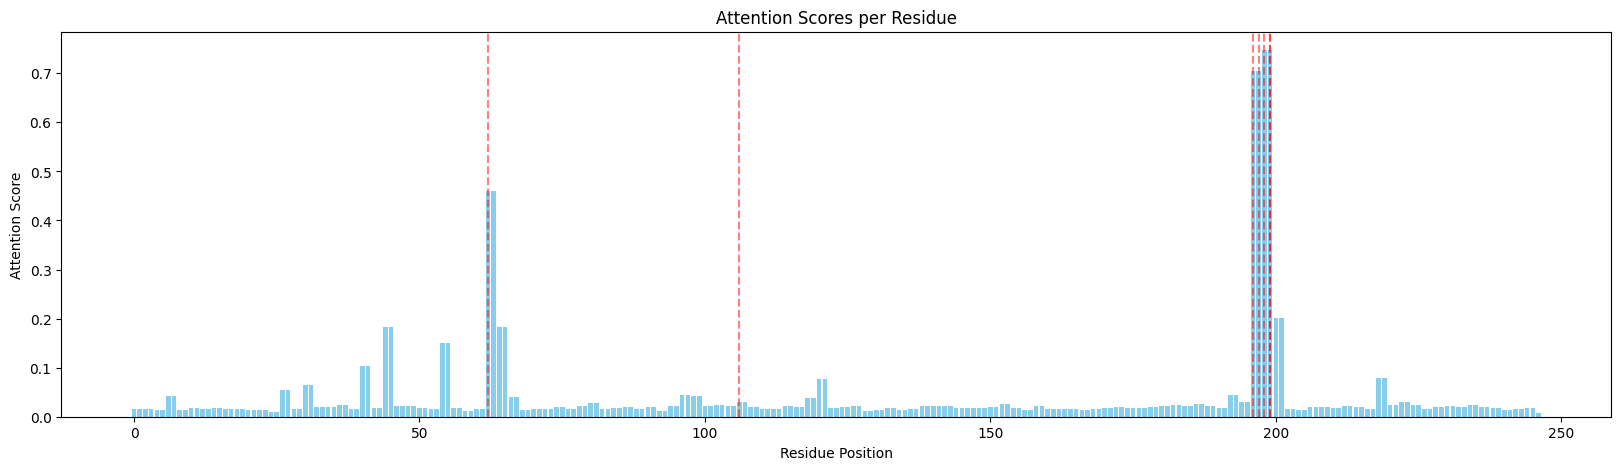

Heatmap saved as attention_heatmap.pdf


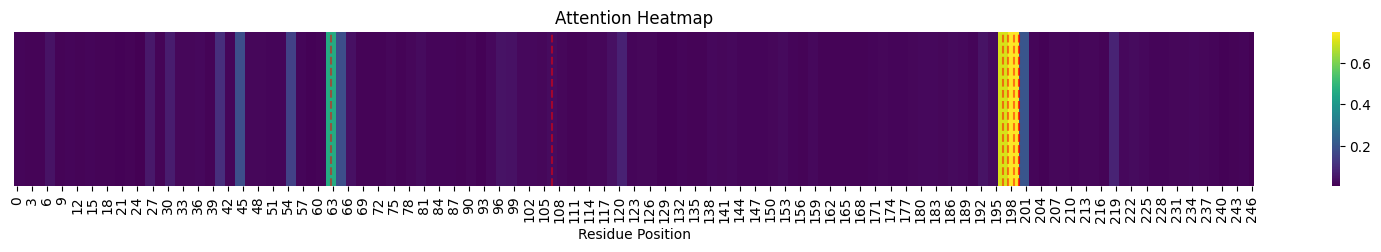

tensor([True])


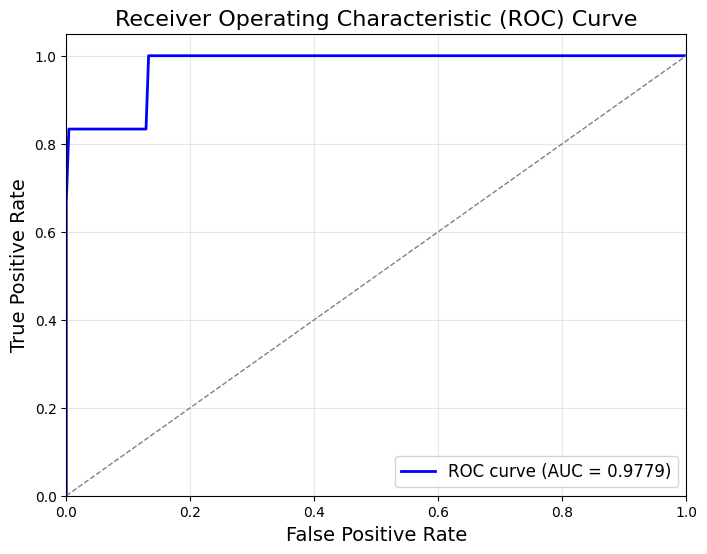

In [74]:
#Training set
Trypsin = "MNLLLILTFVAAAVAAPFDDDDKIVGGYICEENSVPYQVSLNSGYHFCGGSLISEQWVVSAAAAYKSRIQVRLGEHNIEVLEGNEQFINAAKIIRHPKYNSRTLDNDILLIKLSSPAVINSRVSAISLPTAPPAAGTESLISGWGNTLSSGADYPDELQCLDAPVLSQAECEASYPGKITNNMFCVGFLEGGKDSCQGDSGGPVVSNGELQGIVSWGYGCAQKNRPGVYTKVYNYVDWIKDTIAANS"
sample_functional_positions = [197, 107, 199, 63, 200, 200, 198] #[101, 48, 198, 173]
pdb_file = 'AF-P07478-F1-model_v4.pdb'
visualize_sequence_attention(model_check, Trypsin, sample_functional_positions)
generate_roc_curve(model_check, Trypsin, pdb_file, sample_functional_positions, threshold_distance=3.0, max_length=300)

tensor([True])
Top 30 attention positions and scores:
1. Position: 218 (Residue: D), Score: 0.6775
2. Position: 217 (Residue: G), Score: 0.6775
3. Position: 216 (Residue: S), Score: 0.6546
4. Position: 215 (Residue: R), Score: 0.6546
5. Position: 135 (Residue: Y), Score: 0.5279
6. Position: 136 (Residue: G), Score: 0.5279
7. Position: 195 (Residue: C), Score: 0.4038
8. Position: 196 (Residue: H), Score: 0.4038
9. Position: 88 (Residue: L), Score: 0.3063
10. Position: 87 (Residue: E), Score: 0.3063
11. Position: 45 (Residue: V), Score: 0.2535
12. Position: 46 (Residue: R), Score: 0.2535
13. Position: 243 (Residue: L), Score: 0.1331
14. Position: 244 (Residue: K), Score: 0.1331
15. Position: 42 (Residue: R), Score: 0.1294
16. Position: 41 (Residue: L), Score: 0.1294
17. Position: 213 (Residue: Y), Score: 0.0876
18. Position: 214 (Residue: Q), Score: 0.0876
19. Position: 110 (Residue: D), Score: 0.0876
20. Position: 109 (Residue: W), Score: 0.0876
21. Position: 99 (Residue: K), Score: 0.0

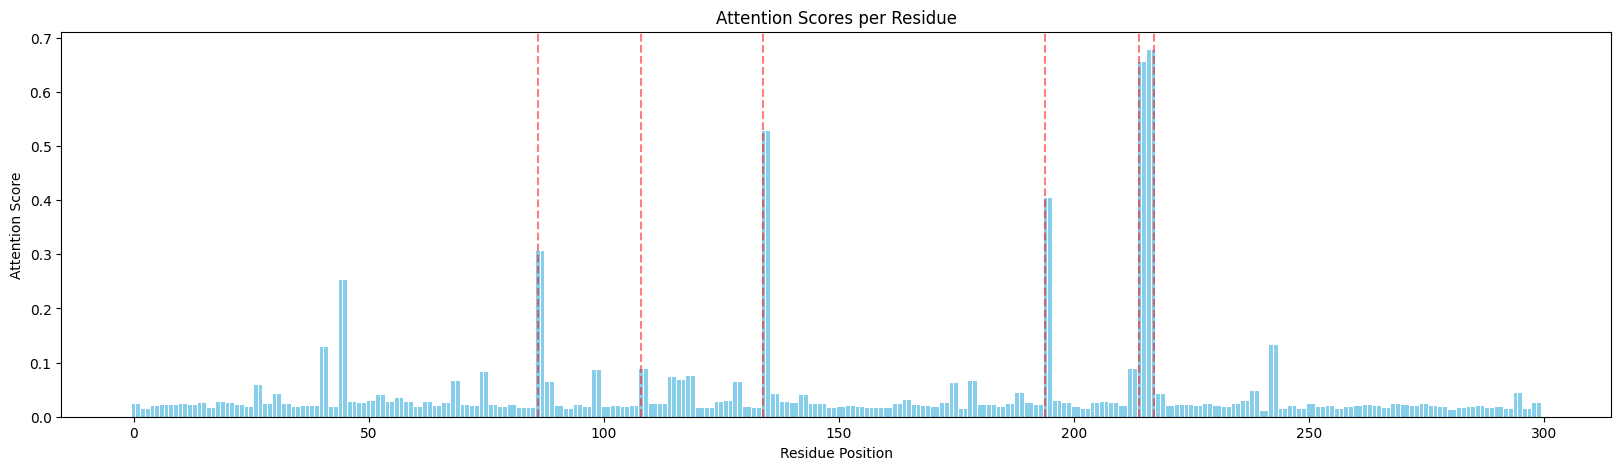

Heatmap saved as attention_heatmap.pdf


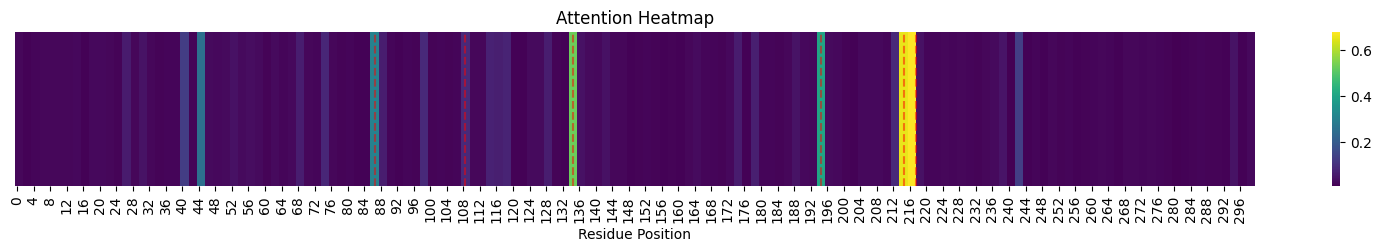

tensor([True])
Curve saved as attention_roc.pdf


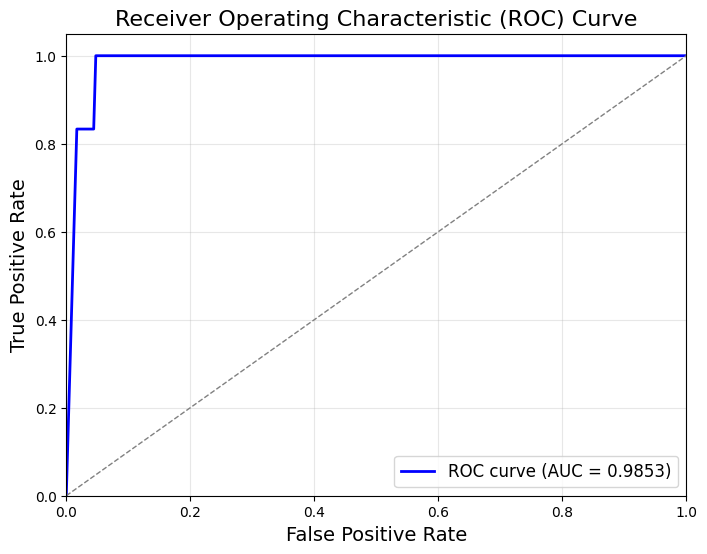

In [66]:
#Validation set
thymidylate_synthase = "MPVAGSELPRRPLPPAAQERDAEPRPPHGELQYLGQIQHILRCGVRKDDRTGTGTLSVFGMQARYSLRDEFPLLTTKRVFWKGVLEELLWFIKGSTNAKELSSKGVKIWDANGSRDFLDSLGFSTREEGDLGPVYGFQWRHFGAEYRDMESDYSGQGVDQLQRVIDTIKTNPDDRRIIMCAWNPRDLPLMALPPCHALCQFYVVNSELSCQLYQRSGDMGLGVPFNIASYALLTYMIAHITGLKPGDFIHTLGDAHIYLNHIEPLKIQLQREPRPFPKLRILRKVEKIDDFKAEDFQIEGYNPHPTIKMEMAV"
sample_functional_positions = [195, 109, 135, 218, 215, 87]
pdb_file = 'AF-P04818-F1-model_v4.pdb'
visualize_sequence_attention(model_check, thymidylate_synthase, sample_functional_positions)
generate_roc_curve(model_check, thymidylate_synthase, pdb_file, sample_functional_positions, threshold_distance=3.0, max_length=300, save_path = 'attention_roc.pdf')